# Variational Domain Translation

#### Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pyro
import pyro.infer
import pyro.poutine

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter

import warnings
# warnings.simplefilter("always", UserWarning)

np.random.seed(0)
torch.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


#### Tensorboard logging

In [2]:
import pathlib

cont_run = ''
# cont_run = './logs/run1'

if not cont_run:
    logdir = pathlib.Path('./logs')
    i = 1
    while (logdir/f'run{i}').exists():
        i += 1
    logdir = logdir/f'run{i}'
    logdir.mkdir(parents=True, exist_ok=True)
else:
    logdir = pathlib.Path(cont_run)
    assert logdir.exists(), f'specified logdir "{cont_run}" does not exist!'

writer = SummaryWriter(logdir)
print(f'Logging to: {logdir}')

Logging to: logs\run2


#### Hyperparameters

In [3]:
import yaml

hparams_file = ''
# hparams_file = './hparams.yaml'

if hparams_file:
    with open(hparams_file) as f:
        hparams = yaml.safe_load(f)
else:
    hparams = {
        'image_size': [3, 32, 32],
        'batch_size': 64,
        'num_epochs': 1000,
        'val_every': 1,
        # optim hparams
        'lr': 2.0e-4,               # don't set too low, or stability issues may arise
        'betas': [0.5, 0.999],
        'clip_grad': 1.0,
        'prior_update': 100,
        # model hparams
        'cls': 1.0e3,               # initial weight of cls. loss
        'cls_decay': 1.0e-1,        # exp decay rate
        'ent_reg': 1.0e-5,          # weight of entropy regularization
    }

writer.add_hparams(
    {k: v for k, v in hparams.items() if not isinstance(v, list)},
    {}
)
writer.add_text('hparams', yaml.dump(hparams, sort_keys=False))

#### Prepare dataset

In [4]:
from dataset.mnist2usps import MNIST2USPS

input_shape = hparams['image_size']
batch_size = hparams['batch_size']
val_split = 0.2

dataset = MNIST2USPS(image_size=input_shape[1:], batch_size=batch_size, val_split=val_split)
s_train_loader, s_val_loader, s_test_loader = dataset.get_loaders('src')
t_train_loader, t_val_loader, t_test_loader = dataset.get_loaders('tgt')

##### Visualize some samples

torch.Size([50, 3, 32, 32]) torch.Size([50])


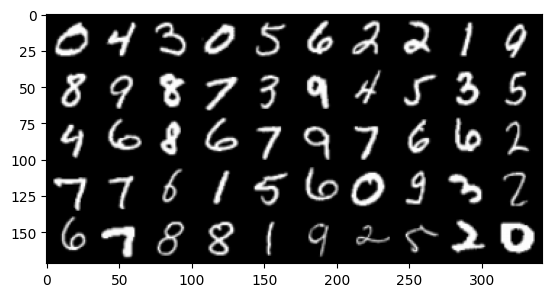

torch.Size([50, 3, 32, 32]) torch.Size([50])


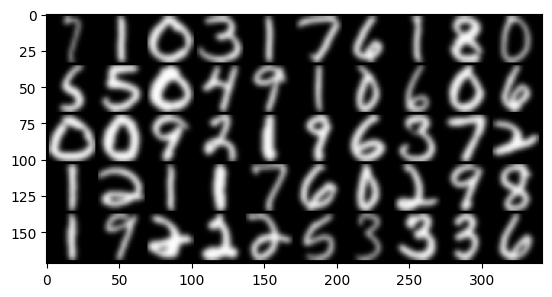

In [5]:
import torchvision
import torchvision.transforms.v2 as v2

num_samples = 50

samples = next(iter(s_train_loader))
xs, ys = samples[0][:num_samples], samples[1][:num_samples]

print(xs.shape, ys.shape)
grid_img = torchvision.utils.make_grid(xs, nrow=10)
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

samples = next(iter(t_train_loader))
xt, yt = samples[0][:num_samples], samples[1][:num_samples]

print(xt.shape, yt.shape)
grid_img = torchvision.utils.make_grid(xt, nrow=10)
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

#### Build the model

In [6]:
from model.network import VDTNet
model = VDTNet(hparams=hparams).to(device)

from torchinfo import summary
print(summary(model, input_size=(batch_size, *input_shape), depth=5))

c:\Users\xuanr\Desktop\Projects\vdt2-pyro\model\block_cnn.py:94: UserWarning: incompatible la_dim=64 and in_shape=(512, 2, 2). nn.Linear used to reshape.
  warnings.warn(f'incompatible la_dim={la_dim} and in_shape={in_shape}. nn.Linear used to reshape.')


Layer (type:depth-idx)                        Output Shape              Param #
VDTNet                                        [64, 3, 32, 32]           2,707,068
├─Encoder: 1-1                                [64, 32]                  --
│    └─CNN: 2-1                               [64, 512, 2, 2]           --
│    │    └─Sequential: 3-1                   [64, 512, 2, 2]           --
│    │    │    └─Conv2d: 4-1                  [64, 64, 32, 32]          1,792
│    │    │    └─BatchNorm2d: 4-2             [64, 64, 32, 32]          128
│    │    │    └─MaxPool2d: 4-3               [64, 64, 16, 16]          --
│    │    │    └─LeakyReLU: 4-4               [64, 64, 16, 16]          --
│    │    │    └─Conv2d: 4-5                  [64, 128, 16, 16]         73,856
│    │    │    └─BatchNorm2d: 4-6             [64, 128, 16, 16]         256
│    │    │    └─MaxPool2d: 4-7               [64, 128, 8, 8]           --
│    │    │    └─LeakyReLU: 4-8               [64, 128, 8, 8]           --
│   

#### Utility functions

In [7]:
from model.distrib.utils import *

class Visualizer:
    def __init__(
        self,
        model,
        writer,
        device,
        batch_size=64,
        image_keys=('x_A', 'x_B', 'x1_A', 'x1_B', 'x_AB', 'x_BA'),
        embed_keys=(('z_A', 'z_B', 'z_AB', 'z_BA'), ('h_A', 'h_B'))
    ):
        self.model = model
        self.writer = writer

        self.device = device
        self.batch_size = batch_size
        
        self.image_keys = image_keys
        self.embed_keys = embed_keys
    
    def vis_samples(self, samples, step, tag, labels=None, mode='both'):
        outputs_all = {}

        training = self.model.training
        self.model.eval()

        # collect outputs
        with torch.no_grad():
            for i in range(0, len(samples), self.batch_size):
                if mode == 'src' or mode == 'tgt':
                    x = torch.stack(samples[i:i+self.batch_size]).to(self.device)
                    if labels is not None:
                        y = torch.stack(labels[i:i+self.batch_size]).to(self.device)
                    else:
                        y = None
                    outputs = self.model(x, y, d=mode)
                
                elif mode == 'both':
                    x_A = torch.stack(samples[0][i:i+self.batch_size]).to(self.device)
                    x_B = torch.stack(samples[1][i:i+self.batch_size]).to(self.device)
                    if labels is not None:
                        y_A = torch.stack(labels[0][i:i+self.batch_size]).to(self.device)
                        y_B = torch.stack(labels[1][i:i+self.batch_size]).to(self.device)
                    else:
                        y_A = None
                        y_B = None
                    outputs = self.model(x_A, y_A, d='src')
                    outputs.update(self.model(x_B, y_B, d='tgt'))
                
                else:
                    raise ValueError(f'invalid mode={mode}')
                
                for k, v in outputs.items():
                    if v is None:
                        continue
                    if k not in outputs_all:
                        outputs_all[k] = []
                    outputs_all[k] += [v]
        
        self.model.train(training)
        
        # concatenate output tensors
        for k, v in outputs_all.items():
            outputs_all[k] = torch.cat(v, dim=0)
        
        # visualize images
        for k in self.image_keys:
            if k in outputs_all:
                writer.add_images(f'{tag}/{k}', outputs_all[k], step)
        
        # visualize embeddings
        for group in self.embed_keys:
            g_embed_mat = []
            g_metadata = []
            g_label_img = []
            g_tags = []

            for k in group:
                if k in outputs_all:
                    embed = outputs_all[k].flatten(1)
                    g_embed_mat += [embed]
                    g_metadata += [k] * embed.shape[0]
                    g_tags += [k]
                    if k.endswith('AB'):
                        g_label_img += [outputs_all['x_AB']]
                    elif k.endswith('BA'):
                        g_label_img += [outputs_all['x_BA']]
                    elif k.endswith('A'):
                        g_label_img += [outputs_all['x_A']]
                    elif k.endswith('B'):
                        g_label_img += [outputs_all['x_B']]
                    else:
                        g_label_img += [torch.zeros(embed.shape[0], *input_shape)]
            
            g_embed_mat = torch.cat(g_embed_mat, dim=0)
            g_label_img = torch.cat(g_label_img, dim=0)

            writer.add_embedding(
                g_embed_mat,
                metadata=g_metadata,
                label_img=g_label_img,
                global_step=step,
                tag=f'{tag}/{",".join(g_tags)}'
            )
    
    def vis_priors(self, step, tag, dims=(0, 1)):
        dims = list(dims)

        mu_zA, mu_zB = self.model.prior_z.mu.numpy(force=True)
        cov_zA, cov_zB = self.model.prior_z.get_cov().numpy(force=True)

        mu_h = self.model.prior_h.mu.numpy(force=True)[0]
        cov_h = self.model.prior_h.get_cov().numpy(force=True)[0]

        fig = plt.figure(figsize=(8, 8))
        plot_2d_gaussian(mu_zA[dims], cov_zA[dims, :][:, dims], label='prior_zA')
        plot_2d_gaussian(mu_zB[dims], cov_zB[dims, :][:, dims], label='prior_zB')
        plot_2d_gaussian(mu_h[dims], cov_h[dims, :][:, dims], label='prior_h')
        writer.add_figure(tag, fig, step)
        fig.clear()
        plt.close(fig)

In [8]:
visualizer = Visualizer(model, writer, device, batch_size=batch_size)
n_vis = 50

vxs_train = [s_train_loader.dataset[i][0] for i in range(n_vis)]
vxt_train = [t_train_loader.dataset[i][0] for i in range(n_vis)]

vxs_val = [s_val_loader.dataset[i][0] for i in range(n_vis)]
vxt_val = [t_val_loader.dataset[i][0] for i in range(n_vis)]

vxs_test = [s_test_loader.dataset[i][0] for i in range(n_vis)]
vxt_test = [t_test_loader.dataset[i][0] for i in range(n_vis)]

visualizer.vis_samples((vxs_train, vxt_train), 0, 'train', mode='both')
visualizer.vis_samples((vxs_val, vxt_val), 0, 'val', mode='both')
visualizer.vis_priors(0, 'priors')

#### Training and evaluation

In [9]:
def evaluate(model, loader_s, loader_t):
    elbo_fn = pyro.infer.Trace_ELBO().differentiable_loss

    loss_dict = {}
    len_loader = min(len(loader_s), len(loader_t))

    training = model.training
    model.eval()
    
    with torch.no_grad():
        for (xs, ys), (xt, yt) in zip(loader_s, loader_t):
            if xs.shape[0] != xt.shape[0]:
                continue
            N = xs.shape[0]
            xs, ys = xs.to(device), ys.to(device)
            xt, yt = xt.to(device), yt.to(device)

            # evaluate ELBO loss
            data_s = (xs, ys, 'src')
            data_t = (xt, yt, 'tgt')

            elbo_s = elbo_fn(model.model, model.guide, *data_s)
            elbo_t = elbo_fn(model.model, model.guide, *data_t)
            loss = elbo_s + elbo_t

            # evaluate classifier accuracy
            model_trace = pyro.poutine.trace(model.model_cls).get_trace(xs)
            ys_pred = model_trace.nodes['cls/y']['fn'].probs

            model_trace = pyro.poutine.trace(model.model_cls).get_trace(xt)
            yt_pred = model_trace.nodes['cls/y']['fn'].probs

            acc_s = (ys_pred.argmax(-1) == ys).sum()
            acc_t = (yt_pred.argmax(-1) == yt).sum()

            loss_dict1 = {
                'loss': loss,
                'elbo_s': elbo_s,
                'elbo_t': elbo_t,
                'acc_s': acc_s,
                'acc_t': acc_t
            }
            for k in loss_dict1:
                if k not in loss_dict:
                    loss_dict[k] = 0
                loss_dict[k] = loss_dict[k] + loss_dict1[k]
    
    model.train(training)

    for k in loss_dict:
        loss_dict[k] = loss_dict[k] / (len_loader*batch_size)
    return loss_dict

##### Training

In [10]:
if cont_run:
    model.load_state_dict(torch.load(logdir/'last_model.pth'))

In [11]:
from model.distrib.dist_fn import *

# ELBO loss functions
elbo_fn_s = pyro.infer.Trace_ELBO().differentiable_loss
elbo_fn_t = pyro.infer.TraceEnum_ELBO(max_plate_nesting=1).differentiable_loss

# setup guide for enumeration
model.enum_guide = pyro.infer.config_enumerate(model.guide, 'sequential', expand=True)

# additional loss functions
cls_loss_fn = nn.CrossEntropyLoss(label_smoothing=0.2)
entropy_fn = EntropyFullGaussian()

# setup optimizer
num_epochs = hparams['num_epochs']
optimizer = torch.optim.Adam(model.parameters(), lr=hparams['lr'], betas=hparams['betas'])

validate_every = hparams['val_every']

model.set_hparams(hparams)
model.train()
step = 0
best_val_loss = np.inf

len_loader = min(len(s_train_loader), len(t_train_loader))

print(f'len(s_train_loader): {len(s_train_loader)}')
print(f'len(t_train_loader): {len(t_train_loader)}')
print(f'len_loader: {len_loader}')

len(s_train_loader): 750
len(t_train_loader): 92
len_loader: 92


In [12]:
for epoch in tqdm(range(num_epochs)):
    # for (xs, ys), (xt, yt) in tqdm(
    #     zip(s_train_loader, t_train_loader), total=len_loader, leave=False
    # ):
    for (xs, ys), (xt, yt) in zip(s_train_loader, t_train_loader):
        if xs.shape[0] != xt.shape[0]:
            continue
        N = xs.shape[0]
        xs, ys = xs.to(device), ys.to(device)
        xt, yt = xt.to(device), yt.to(device)

        mode = int(step % (hparams['prior_update']*2) / hparams['prior_update'])
        if mode == 0:
            model.grad_mode('network')
        elif mode == 1:
            model.grad_mode('priors')
        else:
            raise ValueError(f'invalid mode={mode}')

        # supervised ELBO loss
        elbo_s = elbo_fn_s(model.model, model.guide, xs, ys, d='src')
        elbo_s /= N
        # unsupervised ELBO loss
        elbo_t = elbo_fn_t(model.model, model.enum_guide, xt, None, d='tgt')
        elbo_t /= N
        # total loss
        loss = (elbo_s + elbo_t) / 2

        # additional forward pass
        outputs = {}
        outputs.update(model(xs, None, d='src'))
        outputs.update(model(xt, None, d='tgt'))

        # classifier loss
        weight = hparams['cls'] * np.exp(-hparams['cls_decay'] * step)
        l_cls = cls_loss_fn(outputs['y1_lo_A'], ys)
        # loss += weight * l_cls

        # entropy regularization
        z_all = torch.cat([outputs['z_A'], outputs['z_B']], dim=0)
        ent_z = entropy_fn(z_all.mean(0), torch.cov(z_all.T))
        # loss += hparams['ent_reg'] * -ent_z

        h_all = torch.cat([outputs['h_A'], outputs['h_B']], dim=0)
        ent_h = entropy_fn(h_all.mean(0), torch.cov(h_all.T))
        # loss += hparams['ent_reg'] * -ent_h

        optimizer.zero_grad()
        loss.backward()
        if hparams['clip_grad'] > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), hparams['clip_grad'])
        optimizer.step()

        loss_dict = {
            'loss': loss,
            'elbo_s': elbo_s,
            'elbo_t': elbo_t,
            'l_cls': l_cls,
            'w_cls': weight,
            'ent_z': ent_z,
            'ent_h': ent_h
        }

        step += 1
        for k, v in loss_dict.items():
            writer.add_scalar(f'train/{k}', v.item(), step)
        
        # train statistics
        train_loss_dict = evaluate(model, [(xs, ys)], [(xt, yt)])
        for k, v in train_loss_dict.items():
            writer.add_scalar(f'train-eval/{k}', v.item(), step)
    
    if epoch % validate_every == 0:
        val_loss_dict = evaluate(model, s_val_loader, t_val_loader)
        for k, v in val_loss_dict.items():
            writer.add_scalar(f'val/{k}', v.item(), step)
        
        # visualize
        visualizer.vis_samples((vxs_train, vxt_train), step, 'train', mode='both')
        visualizer.vis_samples((vxs_val, vxt_val), step, 'val', mode='both')
        visualizer.vis_priors(step, 'priors')

        if val_loss_dict['loss'] < best_val_loss:
            best_val_loss = val_loss_dict['loss']
            torch.save(model.state_dict(), logdir/'best_model.pth')

        torch.save(model.state_dict(), logdir/'last_model.pth')

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\xuanr\AppData\Roaming\Python\Python310\site-packages\pyro\primitives.py:478: UserWarning: prior_z.pi was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
C:\Users\xuanr\AppData\Roaming\Python\Python310\site-packages\pyro\primitives.py:478: UserWarning: prior_z.mu was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
C:\Users\xuanr\AppData\Roaming\Python\Python310\site-packages\pyro\primitives.py:478: UserWarning: prior_z.cov_l was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
C:\Users\xuanr\AppData\Roaming\Python\Python310\site-packages\pyro\primitives.py:478: UserWarning: prior_h.pi was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module

#### Evaluate on test set

In [ ]:
model.load_state_dict(torch.load(logdir/'last_model.pth'))
loss_dict = evaluate(model, s_test_loader, t_test_loader)
from pprint import pprint
pprint(loss_dict)

#### Evaluate on test set visually

In [ ]:
model.load_state_dict(torch.load(logdir/'last_model.pth'))
visualizer.vis_samples((vxs_test, vxt_test), step, 'test', mode='both')